In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassF1Score


import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

In [15]:
# # check CPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device

## Read data

In [16]:
data_paths = {
    'train': '/kaggle/input/aiomodule6cassavaleaf/cassavaleafdata/train',
    'valid': '/kaggle/input/aiomodule6cassavaleaf/cassavaleafdata/validation',
    'test' : '/kaggle/input/aiomodule6cassavaleaf/cassavaleafdata/test'
}

# load image from path
def loader(path):
    return Image.open(path)

### class Dataset 

In [17]:
img_size = 224
train_transforms = transforms.Compose([
    transforms.Resize ((img_size, img_size)), # Resize image
    transforms.ToTensor(), # convert to Tensor and normalise to range [0, 1] 
])

train_dataset = datasets.ImageFolder(
    root = data_paths['train'],
    loader = loader,
    transform = train_transforms
)

val_dataset = datasets.ImageFolder(
    root = data_paths['valid'],
    transform = train_transforms
)

test_dataset = datasets.ImageFolder(
    root = data_paths['test'],
    transform = train_transforms
)

print("Class names:", train_dataset.classes)
print("Class to index mapping:", train_dataset.class_to_idx)
print("Number of classes:", len(train_dataset.classes))

Class names: ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']
Class to index mapping: {'cbb': 0, 'cbsd': 1, 'cgm': 2, 'cmd': 3, 'healthy': 4}
Number of classes: 5


In [18]:
loader = DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=2)

# Accumulate sum and squared sum
mean = 0.0
std = 0.0
nb_samples = 0.0

for data, _ in tqdm(loader):
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)  # (B, C, H*W)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f"Mean: {mean}")
print(f"Std: {std}")

100%|██████████| 23/23 [00:41<00:00,  1.80s/it]

Mean: tensor([0.4479, 0.4966, 0.3222])
Std: tensor([0.1918, 0.1923, 0.1654])


In [19]:
additional_train_transform = transforms.Compose([
    transforms.Resize ((img_size, img_size)), # Resize image
    transforms.ToTensor(), # convert to Tensor and normalise to range [0, 1] 
    transforms.Normalize(mean.tolist(), std.tolist()),
    # transforms.RandomCrop(img_size, padding = 5),
    # transforms.RandomErasing(
    #     p = 0.75,
    #     scale = (0.01, 0.3),
    #     ratio = (1.0, 1.0),
    #     value = 0,
    #     inplace = True
    # ),
    # transforms.RandomHorizontalFlip(p = 0.5),
    
])

additional_val_transform = transforms.Compose([
    transforms.Resize ((img_size, img_size)), # Resize image
    transforms.ToTensor(), # convert to Tensor and normalise to range [0, 1] 
    transforms.Normalize(mean.tolist(), std.tolist())
])

train_dataset.transform = additional_train_transform
test_dataset.transform = additional_val_transform
val_dataset.transform = additional_val_transform

In [20]:
# Get one sample from each dataset
train_img, train_label = train_dataset[0]
val_img, val_label = val_dataset[0]
test_img, test_label = test_dataset[0]

print("Number of train samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of test samples:", len(test_dataset))

# Print shapes
print("Train image shape:", train_img.shape)
print("Validation image shape:", val_img.shape)
print("Test image shape:", test_img.shape)

Number of train samples: 5656
Number of validation samples: 1889
Number of test samples: 1885
Train image shape: torch.Size([3, 224, 224])
Validation image shape: torch.Size([3, 224, 224])
Test image shape: torch.Size([3, 224, 224])


In [21]:
batch = 128

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch,
    shuffle = True
)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = batch,
    shuffle = False
)

val_loader = DataLoader(
    dataset = val_dataset,
    batch_size = batch,
    shuffle = False
)

In [22]:
# Print shape of one batch from each loader
train_images, train_labels = next(iter(train_loader))
val_images, val_labels = next(iter(val_loader))
test_images, test_labels = next(iter(test_loader))

print("Train batch - images shape:", train_images.shape)
print("Train batch - labels shape:", train_labels.shape)

print("Validation batch - images shape:", val_images.shape)
print("Validation batch - labels shape:", val_labels.shape)

print("Test batch - images shape:", test_images.shape)
print("Test batch - labels shape:", test_labels.shape)

Train batch - images shape: torch.Size([128, 3, 224, 224])
Train batch - labels shape: torch.Size([128])
Validation batch - images shape: torch.Size([128, 3, 224, 224])
Validation batch - labels shape: torch.Size([128])
Test batch - images shape: torch.Size([128, 3, 224, 224])
Test batch - labels shape: torch.Size([128])


# Build Model

In [23]:
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

In [33]:
import torch
import torch.nn as nn

class PatchPositionEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, img_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = embed_dim, kernel_size = patch_size, stride = patch_size, bias = False)

        scale = embed_dim ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(embed_dim))
        self.positional_embedding = nn.Embedding(num_embeddings= (img_size // patch_size) ** 2 + 1, embedding_dim = embed_dim) 
        # return lookup table

    def forward(self, X):
        device = X.device
        
        X = self.conv1(X) # shape: [B, C, W, H]
        X = X.reshape(X.shape[0], X.shape[1], -1) #[B, C, W*H]
        X = X.permute(0, 2, 1) #[B, W*H, C] = [B, L, D]
        # Expand class_embedding
        cls_embs =self.class_embedding.unsqueeze(0).unsqueeze(1).expand(X.shape[0], 1, -1)
        X = torch.cat([cls_embs, X], dim = 1) # [B, L + 1, D]
        pos_l = torch.arange(X.shape[1]).to(device)
        pos_embed = self.positional_embedding(pos_l)
        X = X + pos_embed

        return X

class AuxiliaryHead(nn.Module):
    def __init__(self, embed_dim, num_classes):
        super().__init__()
        self.aux1 = self._make_aux_head(embed_dim, num_classes)

    def _make_aux_head(self, embed_dim, num_classes):
        return nn.Sequential(
                # nn.AdaptiveAvgPool1d(1),
                nn.Flatten(),
                nn.Linear(embed_dim, num_classes))
    
    def forward(self, X):
        # X = X.transpose(1, 2)
        output = self.aux1(X)
        return output

In [34]:
class transformer_layer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim = embed_dim, 
                                          num_heads = num_heads,
                                         batch_first = True)
        self.ffn = nn.Sequential (
                nn.Linear( in_features = embed_dim , out_features = ff_dim , bias = True ) ,
                nn.LeakyReLU(0.1) ,
                nn.Linear( in_features = ff_dim , out_features = embed_dim , bias = True )
        )
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, Q, K, V):
        attn_output , _ = self.attn(Q, K, V)
        attn_output = self.dropout(attn_output)
        out_1 = self.layer_norm_1(Q + attn_output)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout(ffn_output)
        out_2 = self.layer_norm_2(out_1 + ffn_output)
        return out_2

In [35]:
class VisionTransformerCls(nn.Module):
    def __init__(self, image_size, embed_dim, num_heads, ff_dim, num_layers,
                dropout =0.1, num_classes = 10, patch_size = 16):
        super().__init__()
        self.embed_layer = PatchPositionEmbedding(
            img_size = image_size, embed_dim = embed_dim, patch_size = patch_size
        )
        
        self.transform_layers_list = nn.ModuleList([
            transformer_layer(num_heads=num_heads, embed_dim=embed_dim, ff_dim=ff_dim)
            for _ in range(num_layers)
        ])
    
        self.classifier = nn.Sequential(
            nn.Linear(in_features = embed_dim, out_features = 20),
            nn.LeakyReLU(0.1),
            nn.Dropout(p = dropout),
            nn.Linear(in_features = 20, out_features = num_classes),
        )
        
        self.num_lays = num_layers
        self.auxiliary_head = AuxiliaryHead(embed_dim, num_classes)

    def forward(self, X):
        main_output = self.embed_layer(X)
        aux_outputs = []
        counter = 0 # used to help remove aux_head for last transformer layer

        for layer in self.transform_layers_list:
            counter += 1
            main_output = layer(main_output, main_output, main_output)

            if counter < self.num_lays:
                aux_output = self.auxiliary_head(main_output[:, 0, :])
                aux_outputs.append(aux_output)

        
        main_output = main_output[:, 0, :] # get only first L
        main_output = self.classifier(main_output)
        
        return main_output, aux_outputs

In [36]:
hyperparameter = {
    "num_classes": len(train_dataset.classes),
    "image_size": img_size, 
    "patch_size": 16,
    "embed_dim": 512, 
    "ff_dim": 1024,
    "num_heads": 8,
    "num_layers": 5
}
 
model = VisionTransformerCls(**hyperparameter)
model

VisionTransformerCls(
  (embed_layer): PatchPositionEmbedding(
    (conv1): Conv2d(3, 512, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (positional_embedding): Embedding(197, 512)
  )
  (transform_layers_list): ModuleList(
    (0-4): 5 x transformer_layer(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=512, out_features=1024, bias=True)
        (1): LeakyReLU(negative_slope=0.1)
        (2): Linear(in_features=1024, out_features=512, bias=True)
      )
      (layer_norm_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (layer_norm_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=20, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.1, inplace=False)
    (3)

In [37]:
import torch
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

summary(model.to(device), (1, 3, img_size, img_size))  # Input shape does NOT include batch size

Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformerCls                     [1, 5]                    --
├─PatchPositionEmbedding: 1-1            [1, 197, 512]             512
│    └─Conv2d: 2-1                       [1, 512, 14, 14]          393,216
│    └─Embedding: 2-2                    [197, 512]                100,864
├─ModuleList: 1-10                       --                        (recursive)
│    └─transformer_layer: 2-3            [1, 197, 512]             --
│    │    └─MultiheadAttention: 3-1      [1, 197, 512]             1,050,624
│    │    └─Dropout: 3-2                 [1, 197, 512]             --
│    │    └─LayerNorm: 3-3               [1, 197, 512]             1,024
│    │    └─Sequential: 3-4              [1, 197, 512]             1,050,112
│    │    └─Dropout: 3-5                 [1, 197, 512]             --
│    │    └─LayerNorm: 3-6               [1, 197, 512]             1,024
├─AuxiliaryHead: 1-3                     [1, 

# Set up Training Session

In [38]:
def evaluate(model, test_dataloader, criterion, metric, device):
    model.eval()
    losses = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass - only use main output
            main_out, _ = model(inputs)  # Ignore auxiliary outputs

            loss = criterion(main_out, labels)
            losses.append(loss.item())

            _, predicted = torch.max(main_out, 1)
            metric.update(predicted, labels)

    avg_loss = sum(losses) / len(losses)
    metric_score = metric.compute().item()

    return avg_loss, metric_score


In [39]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    metric,
    optimizer,
    device,
    epochs,
    aux_weights=None  # List of weights, e.g., [0.3, 0.3, 0.2]
):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    best_model_state = None
    best_score = 0

    model.to(device)

    # if aux_weights is None:
    #     aux_weights = [0.3] * (len(model.aux_heads))  # Default values

    # assert len(aux_weights) == len(model.aux_heads), (
    #     f"Expected {len(model.aux_heads)} auxiliary weights, but got {len(aux_weights)}"
    # )
    aux_weights = [0.3] * (model.num_lays - 1)

    for epoch in range(epochs):
        batch_train_losses = []
        model.train()
        metric.reset()    
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            main_out, aux_outs = model(inputs)  # <--- Unpack outputs

            # Compute main loss
            loss = criterion(main_out, labels)

            # Add auxiliary losses
            for aux_out, weight in zip(aux_outs, aux_weights):
                loss += weight * criterion(aux_out, labels)

            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

            _, predicted = torch.max(main_out, 1)  # Use main_out for accuracy
            metric.update(predicted, labels)

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        train_acc = metric.compute().item()
        train_accs.append(train_acc)

        # Validate
        val_loss, val_acc = evaluate(
            model, val_loader, criterion, metric, device
        )
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(
            f"""
            EPOCH {epoch + 1}:\n
            \tTrain loss: {train_loss:.4f}\tTrain Acc: {train_acc:.4f}\n
            \tVal loss: {val_loss:.4f}\tVal Acc: {val_acc:.4f}
            """)

        if val_acc > best_score:
            best_score = val_acc
            best_model_state = model.state_dict()
            print("=====================")
            print(f"Epoch {epoch+1}: New best score on val = {best_score:.4f}, saving model...") 
            print("=====================")

    return train_losses, train_accs, val_losses, val_accs, best_model_state


In [40]:
hyperparameter = {
    "num_classes": len(train_dataset.classes),
    "image_size": img_size, 
    "patch_size": 16,
    "embed_dim": 512, 
    "ff_dim": 1024,
    "num_heads": 8,
    "num_layers": 5,
}
 
model = VisionTransformerCls(**hyperparameter)

lr = 0.0005
epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
metric = MulticlassF1Score(num_classes=len(train_dataset.classes), average='macro').to(device)

In [41]:
results = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    metric,
    optimizer,
    device,
    epochs
)


            EPOCH 1:

            	Train loss: 3.0090	Train Acc: 0.1688

            	Val loss: 1.3459	Val Acc: 0.1745
            
Epoch 1: New best score on val = 0.1745, saving model...

            EPOCH 2:

            	Train loss: 2.7795	Train Acc: 0.2247

            	Val loss: 1.3625	Val Acc: 0.2270
            
Epoch 2: New best score on val = 0.2270, saving model...

            EPOCH 3:

            	Train loss: 2.6947	Train Acc: 0.2392

            	Val loss: 1.2733	Val Acc: 0.2417
            
Epoch 3: New best score on val = 0.2417, saving model...

            EPOCH 4:

            	Train loss: 2.5475	Train Acc: 0.2644

            	Val loss: 1.1998	Val Acc: 0.2648
            
Epoch 4: New best score on val = 0.2648, saving model...

            EPOCH 5:

            	Train loss: 2.4484	Train Acc: 0.2833

            	Val loss: 1.2539	Val Acc: 0.2831
            
Epoch 5: New best score on val = 0.2831, saving model...

            EPOCH 6:

            	Train loss: 2.

In [42]:
def plot_results(Training_Loss, Training_Acc, val_Loss, val_Acc):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(Training_Loss, color="blue", label="Training Loss")
    plt.plot(val_Loss, color="green", label="val Loss")
    plt.title("Training and val Loss curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss value")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(Training_Acc, color="blue", label="Training Accuracy")
    plt.plot(val_Acc, color="green", label="val Accuracy")
    plt.title("Training and val Accuracy curves")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy value")
    plt.legend()

    plt.tight_layout()
    plt.show()

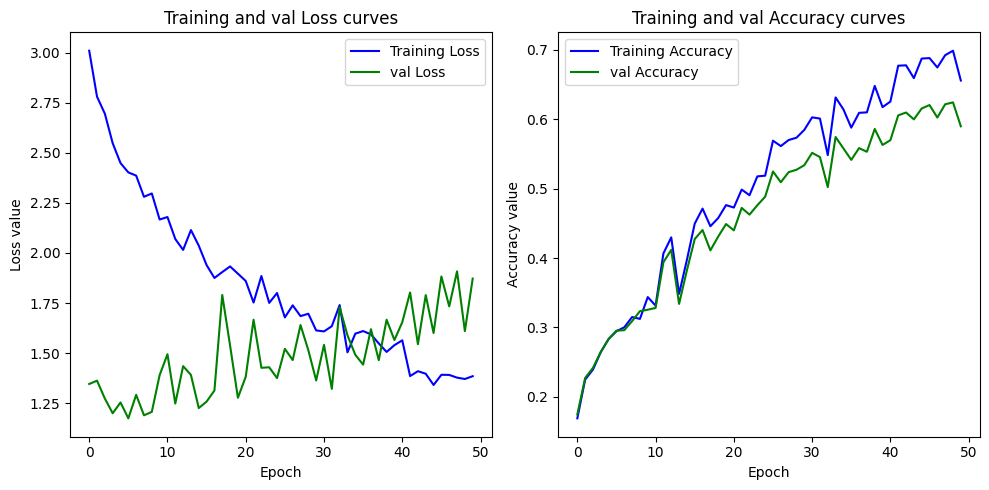

In [43]:
plot_results(results[0], results[1], results[2], results[3])

# Eval

In [44]:
model.load_state_dict(results[4])
test_loss, test_acc = evaluate(
    model.to(device), test_loader, criterion, metric, device
)

print(test_loss, test_acc)

1.828160325686137 0.549426794052124
